In [29]:
import torch
from torch import nn
import gpytorch
from torchsummary import summary

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc

from warp_units import *
from func_polygon import *
from func_data_generation import *

from utils import *

dtype=torch.double
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

torch.set_default_dtype(dtype)
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using cuda device
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
class WarpModel(torch.nn.Sequential):
    def __init__(self):
        super(WarpModel, self).__init__()
        self.add_module('axial_dim0', AxialWarpUnit(dim=0, res=50, grad=20, lims=[0, 1.0]))
        self.add_module('axial_dim1', AxialWarpUnit(dim=1, res=50, grad=20, lims=[-1.0, 0]))
        self.add_module('rbf_seq1', rbfunit_sequential(res=1, ylim=[-1, 0]))
        self.add_module('rbf_seq2', rbfunit_sequential(res=2, ylim=[-1, 0]))
        self.add_module('mobius', MobiusWarpUnit())
        
        
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood, warp_model):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ZeroMean()
#             self.covar_module = gpytorch.kernels.GridInterpolationKernel(
#                 gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
#                 num_dims=2, grid_size=100
#             )
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
            self.space_transform = warp_model

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            # We're also scaling the features so that they're nice values
            projected_x = self.space_transform(x)
            projected_x = projected_x - projected_x.min(0)[0]
            projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [3]:
random_seed = 100

np.random.seed(random_seed) 
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

warp_model = WarpModel()

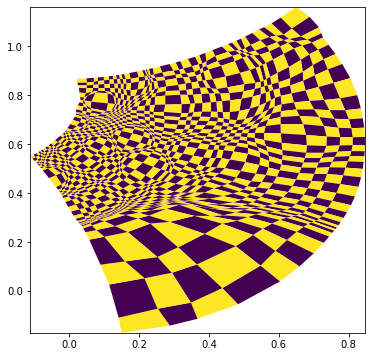

In [4]:
chessboard_from_model(warp_model)

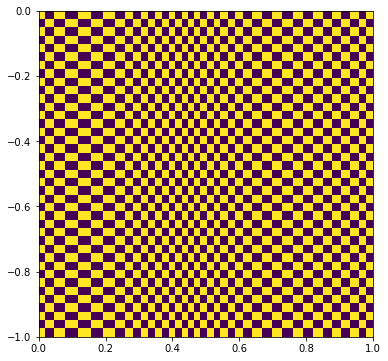

In [5]:
chessboard_from_model(warp_model.axial_dim0)

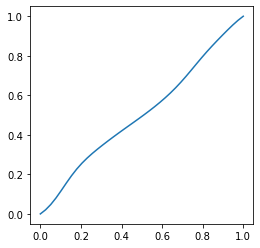

In [6]:
oned_map(warp_model.axial_dim0, dim=0)

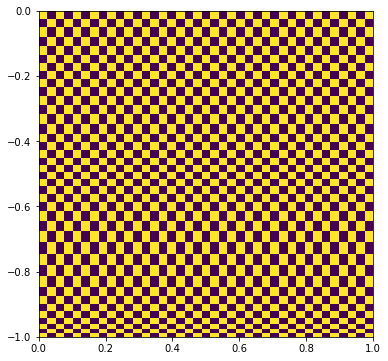

In [7]:
chessboard_from_model(warp_model.axial_dim1)

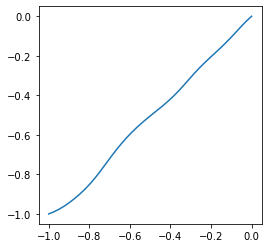

In [8]:
oned_map(warp_model.axial_dim1, dim=1)

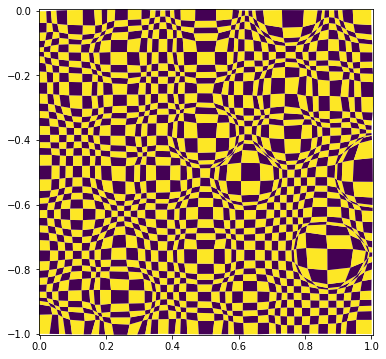

In [9]:
chessboard_from_model(warp_model.rbf_seq2)

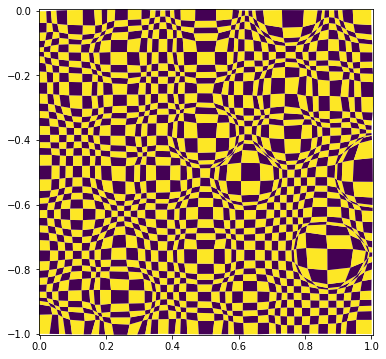

In [10]:
chessboard_from_model(warp_model.rbf_seq2)

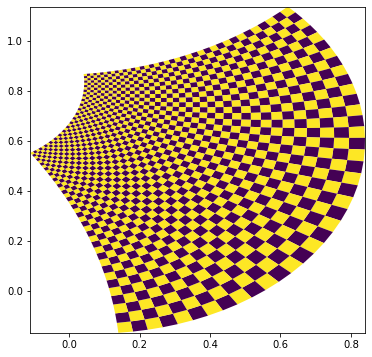

In [11]:
chessboard_from_model(warp_model.mobius)

In [12]:
for name, param in gp_model.named_parameters():
    print(f"Layer:{name} | Size:{param.size()} | Values : {param} \n")
#     print(f"Layer:{name} | Size:{param.size()} |  \n")


NameError: name 'gp_model' is not defined

## Data Generation

1000 * 1000 的场地上，生成1000 * 1000个点的数据

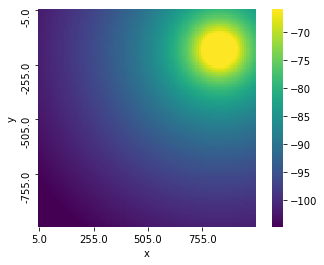

In [17]:
tran_x = torch.rand(()) * 1000
tran_y = -torch.rand(()) * 1000
tran_loc = torch.stack((tran_x, tran_y), dim=-1)

coords, rss = get_field_data(100, 30, tran_loc)  # 200*200显存上限
coords = coords.to(device)
rss = rss.to(device)

In [18]:
tran_loc

tensor([ 835.1117, -187.4723])

In [19]:
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
gp_model = GPRegressionModel(train_x=None, train_y=None, likelihood=likelihood, warp_model=warp_model).to(device)


In [20]:
gp_model.covar_module.base_kernel.lengthscale = torch.tensor([[0.1, ]]).to(device)
gp_model.covar_module.outputscale = torch.tensor(16.0).to(device)

In [21]:
# # change parameter value
# gp_state_dict = gp_model.state_dict()
# gp_state_dict['covar_module.base_kernel.raw_lengthscale'] = torch.tensor([[0.4,]]).to(device)
# gp_state_dict['covar_module.raw_outputscale'] = torch.tensor(64.0).to(device)
# gp_model.load_state_dict(gp_state_dict)

In [22]:
likelihood.eval()
gp_model.eval()
observed_pred = likelihood(gp_model(coords/1000))


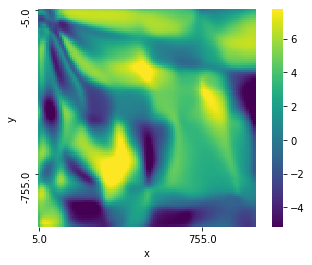

In [23]:
shadow = observed_pred.sample()
plot_heatmap(coords, shadow)
# shadow = shadow.reshape(200, 200).numpy()

In [24]:
y = rss + shadow

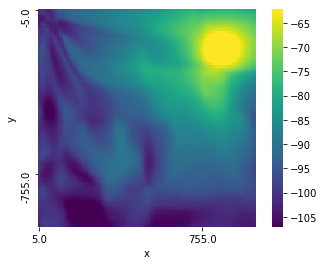

In [25]:
plot_heatmap(coords, y)

# choose 100 points evenly distributed in the area 1000 * 1000

In [26]:
train_X, train_y, idx = random_choose(coords,  y, num=500)

In [27]:
idx.shape

torch.Size([500])

Saving figure system_model


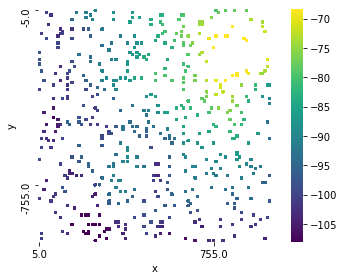

In [30]:
plot_heatmap(coords, y, mask_idx=idx)
save_fig("system_model")

In [324]:
DATA_PATH

'./data'

In [325]:
torch.save(train_X/1000, DATA_PATH+'/train_X')
torch.save(train_y, DATA_PATH+'/train_y')

In [294]:

point = torch.tensor([[2.5, -2.5]]).to(device)
warp_model(point)

tensor([[-0.0647,  0.8982]], device='cuda:0', grad_fn=<StackBackward>)

In [238]:
train_X/1000

tensor([[ 0.8750, -0.5650],
        [ 0.7750, -0.9150],
        [ 0.0250, -0.4150],
        ...,
        [ 0.2750, -0.7150],
        [ 0.1850, -0.2450],
        [ 0.5950, -0.0550]], device='cuda:0')